# SYDE 556/750 --- Assignment 1
**Student ID: 20757197**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_01/syde556_assignment_01.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize # For question 2.1b)

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Representation of Scalars

## 1.1 Basic encoding and decoding

**a) Computing gain and bias.** In general, for a neuron model $a = G[J]$ (and assuming that the inverse $J = G^{-1}[a]$ exists), solve the following system of equations to compute the gain $\alpha$, and the bias $J^\mathrm{bias}$ given a maximum rate $a^\mathrm{max}$ and an $x$-intercept $\xi$.

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$

For ease of writing, I'll label G inverse as G_inverse, the threshold current as J_thresh, and the x intercept as x_int

Equations:

1: a_max = G[α + J_bias] -> α + J_bias = G_inverse[a_max]

2: G[α * x_int + J_bias] = 0 -> J_bias = G_inverse[0] - α * x_int

With G_inverse[0] being J_thresh:

J_bias = J_thresh - α * x_int

Subbing 2 into 1:

α + J_thresh - α * x_int = G_inverse[a_max] -> (1-x_int)α = G_inverse[a_max] - J_thresh

-> α = (G_inverse[a_max] - J_thresh) / (1-x_int)

Sub α into 2:

J_bias = J_thresh - ((G_inverse[a_max] - J_thresh) / (1-x_int))x_int

-> J_bias = (J_thresh*(1-x_int) - (G_inverse[a_max] - J_thresh)x_int)/(1-x_int)

-> J_bias = (J_thresh - x_int * G_inverse[a_max])/(1-x_int)

Giving us the following equations for α and J_bias:

α = (G_inverse[a_max] - J_thresh) / (1-x_int)

J_bias = (J_thresh - x_int * G_inverse[a_max])/(1-x_int)

Now, simplify these equations for the specific case $G[J] = \max(J, 0)$.

α steps:

α = (G_inverse[a_max] - J_thresh) / (1-x_int)

Using that a_max is non-zero, inversing it will give itself, which can be written as:
G_inverse[a_max] is just a_max

Also, as this case is using the ReLU model, J_thresh is 0 since anything  >=0 induces a spike. This gives:

α = a_max/(1-x_int)

J_bias steps:

Using the same logic as above,

J_bias = (1 - x_int * a_max)/(1-x_int)

**b) Neuron tuning curves.** Plot the neuron tuning curves $a_i(x)$ for 16 randomly generated neurons following the intercept and maximum rate distributions described above.

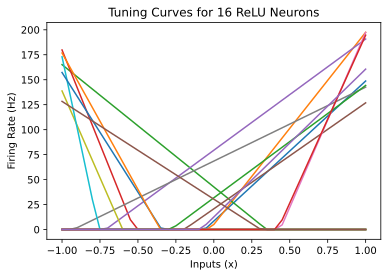

In [2]:
class NeuronModel:
    def __init__(self, a_max, x_int, G=lambda x: max(x, 0)):  
        self.a_max = a_max
        self.x_int = x_int
        self.G = G
        self.encoder = np.random.choice([-1,1])  # random encoder value
        
        # changed from writing as α to alpha for ease of typing
        self.alpha = self._calc_alpha()
        self.j_bias = self._calc_j_bias()
        
    def _calc_j_bias(self):
        top = -1 * self.x_int * self.a_max
        bot = 1 - self.x_int
        return top / bot

    def _calc_alpha(self):
        top = self.a_max
        bot = 1 - self.x_int
        return top / bot
    
    def sim(self,x):
        self.a = [
            self.G(self.encoder*self.alpha*xs + self.j_bias)
            for xs in x
        ]
        return self.a

x = np.linspace(-1,1,41)
n_neurons = 16

# getting random a_max and x-intercept samples
samples_a_max = np.random.uniform(100,200,n_neurons)
samples_x_int = np.random.uniform(-0.95,0.95,n_neurons)

neurons = []

for a_max, x_int in zip(samples_a_max,samples_x_int):
    neuron = NeuronModel(
        a_max=a_max,
        x_int=x_int
    )
    plt.plot(x, neuron.sim(x))
    neurons.append(neuron)
plt.title("Tuning Curves for 16 ReLU Neurons")
plt.xlabel("Inputs (x)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

**c) Computing identity decoders.** Compute the optimal identity decoder $\vec d$ for those 16 neurons (as shown in class). Report the value of the individual decoder coefficients. Compute $d$ using the matrix notation mentioned in the course notes. Do not apply any regularization. $A$ is the matrix of activities (the same data used to generate the plot in 1.1b).

In [3]:
def calc_decoder(A,X):
    return np.linalg.lstsq(A.T,X.T,rcond=None)[0].T

A = np.array([neuron.a for neuron in neurons])

X = x.reshape(1,-1)


decoder = calc_decoder(A,X)

print("decoder matrix:",decoder)
print("The shape of the decoder matrix is:",decoder.shape)

decoder matrix: [[-6.84396065e-04  2.23289548e-04 -4.70247749e-03 -3.01048659e-04
  -5.25274611e-04 -1.83602751e-03 -2.90982032e-03 -8.75973780e-04
   1.77910608e-04  9.05561544e-05 -2.23923278e-02  1.70203040e-02
   8.34612736e-03  4.04760113e-03  6.11897012e-04  2.34378302e-03]]
The shape of the decoder matrix is: (1, 16)


**d) Evaluating decoding errors.** Compute and plot $\hat{x}=\sum_i d_i a_i(x)$. Overlay on the plot the line $y=x$. Make a separate plot of $x-\hat{x}$ to see what the error looks like. Report the Root Mean Squared Error (RMSE) value.

Text(0, 0.5, 'RMSE value (x_hat-x)')

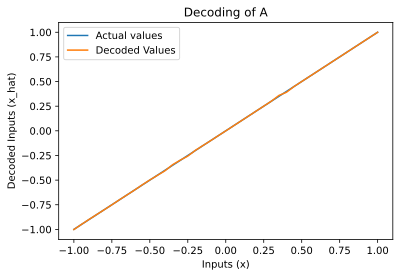

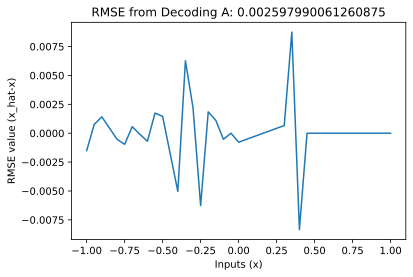

In [4]:
def calc_RMSE(residual):
    return np.sqrt(np.mean(np.square(residual)))

x_decoded = decoder @ A

plt.figure()
plt.plot(x,x,label="Actual values")
plt.plot(x,x_decoded[0],label="Decoded Values")
plt.title("Decoding of A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded = x_decoded[0]-x
plt.figure()
plt.plot(x,residual_x_decoded)
plt.title(f"RMSE from Decoding A: {calc_RMSE(residual_x_decoded)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")

**e) Decoding under noise.** Now try decoding under noise. Add random normally distributed noise to $a$ and decode again. The noise is a random variable with mean $\mu=0$ and standard deviation of $\sigma=0.2 \max(A)$ (where $\max(A)$ is the maximum firing rate of all the neurons). Resample this variable for every different $x$ value for every different neuron. Create all the same plots as in part d). Report the RMSE.

Text(0, 0.5, 'RMSE value (x_hat-x)')

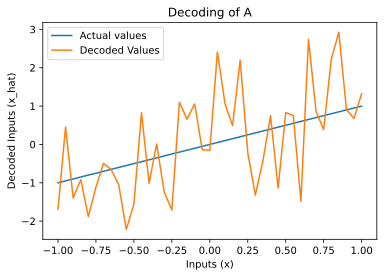

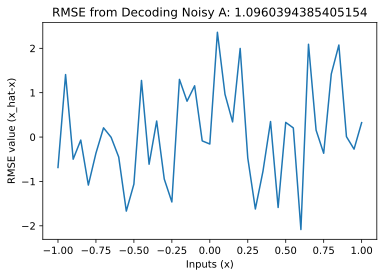

In [5]:
noise_signal = np.random.normal(0,0.2*np.amax(A),A.shape)
A_noisy = A + noise_signal

x_decoded_noisy = decoder @ A_noisy

plt.figure()
plt.plot(x,x,label="Actual values")
plt.plot(x,x_decoded_noisy[0],label="Decoded Values")
plt.title("Decoding of A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded_noisy = x_decoded_noisy[0]-x
plt.figure()
plt.plot(x,residual_x_decoded_noisy)
plt.title(f"RMSE from Decoding Noisy A: {calc_RMSE(residual_x_decoded_noisy)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")

**f) Accounting for decoder noise.** Recompute the decoder $\vec d$ taking noise into account (i.e., apply the appropriate regularization, as shown in class). Show how these decoders behave when decoding both with and without noise added to $a$ by making the same plots as in d) and e). Report the RMSE for all cases.

Text(0, 0.5, 'RMSE value (x_hat-x)')

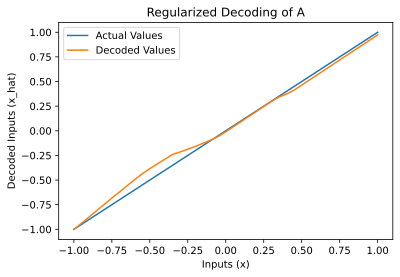

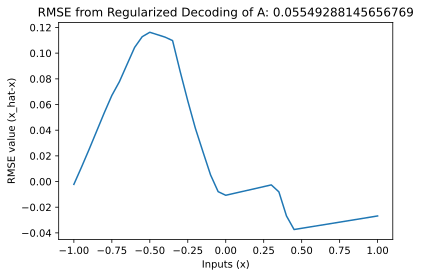

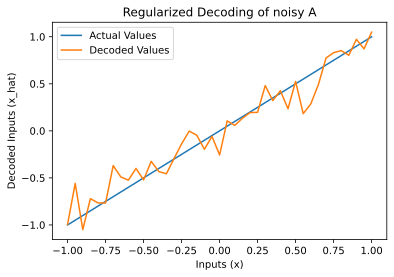

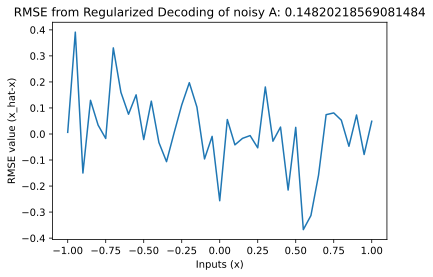

In [6]:
def calc_regularized_decoder(A,X,coefficient=0.2,n_neurons=16):
    N = X.shape[1]
    variance = np.square(coefficient*np.amax(A))

    return np.linalg.lstsq(
        A @ A.T + N*variance*np.eye(n_neurons), A @ X.T, rcond=None
    )[0].T

decoder_reg = calc_regularized_decoder(A,X)

x_decoded_reg = decoder_reg @ A
plt.figure()
plt.plot(x,x,label="Actual Values")
plt.plot(x,x_decoded_reg[0],label="Decoded Values")
plt.title("Regularized Decoding of A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded_reg = x_decoded_reg[0]-x
plt.figure()
plt.plot(x,residual_x_decoded_reg)
plt.title(f"RMSE from Regularized Decoding of A: {calc_RMSE(residual_x_decoded_reg)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")

x_decoded_reg_noisy = decoder_reg @ A_noisy
plt.figure()
plt.plot(x,x,label="Actual Values")
plt.plot(x,x_decoded_reg_noisy[0],label="Decoded Values")
plt.title("Regularized Decoding of noisy A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded_reg_noisy = x_decoded_reg_noisy[0]-x
plt.figure()
plt.plot(x,residual_x_decoded_reg_noisy)
plt.title(f"RMSE from Regularized Decoding of noisy A: {calc_RMSE(residual_x_decoded_reg_noisy)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")

**g) Interpretation.** Show a 2x2 table of the four RMSE values reported in parts d), e), and f). This should show the effects of adding noise and whether the decoders $d$ are computed taking noise into account. Write a few sentences commenting on what the table shows, i.e., what the effect of adding noise to the activities is with respect to the measured error and why accounting for noise when computing the decoders increases/decreases/does not change the measured RMSE.

          Not regularized decoder  Regularized decoder
          
A          0.002597990061260875    0.05549288145656769

Noisy A     1.0960394385405154     0.14820218569081484

From the table above, it can be seen that for not regularized decoders, the RMSE is signficantly worse for noisy activity than not noisy activity. This can be clearly seen when comparing the plots from parts d and e where the non-noisy A is decoded nearly perfectly with a very low RMSE, whereas the noisy A decoding is all over the place with large RMSE. For the regularized decoders, the RMSE is still better for the non-noisy A, however the gap is much less extreme. The RMSE for the regularized non-noisy A is slightly higher than the non-regularized decoding, however the RMSE for the regularized noisy A is significantly better than the non-regularized decoding. This shows that taking noisy into account when computing decoders for measurements that include noise is very important and decreases measured RMSE.

## 1.2 Exploring sources of error

**a) Exploring error due to distortion and noise.** Plot the error due to distortion $E_\mathrm{dist}$ and the error due to noise $E_\mathrm{noise}$ as a function of $n$, the number of neurons. Generate two different loglog plots (one for each type of error) with $n$ values of at least $[4, 8, 16, 32, 64, 128, 256, 512]$. For each $n$ value, do at least $5$ runs and average the results. For each run, different $\alpha$, $J^\mathrm{bias}$, and $e$ values should be generated for each neuron. Compute $d$ taking noise into account, with $\sigma = 0.1 \max(A)$. Show visually that the errors are proportional to $1/n$ or $1/n^2$.

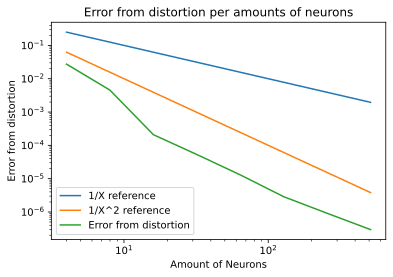

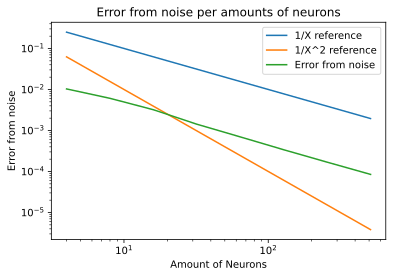

In [7]:
def calc_e_distort(X,A,decoder):
    return 0.5 * np.sum(np.square(X - decoder @ A)) / X.shape[1]

def calc_e_noise(A,decoder,coef):
    return 0.5 * np.square(coef * np.amax(A)) * np.sum(np.square(decoder))

def error_plots(coefficient):
    n_list = [4,8,16,32,64,128,256,512]
    e_distort_list = []
    e_noise_list = []
    for i in n_list:
        e_distort_repeats_list = []
        e_noise_repeats_list = []
        for j in range(5):
            samples_a_max = np.random.uniform(100,200,i)
            samples_x_int = np.random.uniform(-0.95,0.95,i)
            A = np.array([
                NeuronModel(a_max,x_int).sim(x)
                for a_max,x_int in zip(samples_a_max,samples_x_int)
            ])
            decoder = calc_regularized_decoder(A,X,coefficient=coefficient,n_neurons=i)

            e_distort_repeats_list.append(calc_e_distort(X,A,decoder))
            e_noise_repeats_list.append(calc_e_noise(A,decoder,coefficient))

        e_distort_list.append(sum(e_distort_repeats_list) / len(e_distort_repeats_list))
        e_noise_list.append(sum(e_noise_repeats_list) / len(e_noise_repeats_list))
    
    X_samples = np.arange(n_list[0],n_list[-1],0.5)
    y_samples_0 = np.array([1/X for X in X_samples])
    y_samples_1 = np.array([1/np.square(X) for X in X_samples])
    
    # Plot for error caused by distortion
    plt.figure()
    plt.loglog(X_samples,y_samples_0,label="1/X reference")
    plt.loglog(X_samples,y_samples_1,label="1/X^2 reference")
    plt.loglog(n_list,e_distort_list,label="Error from distortion")
    plt.title("Error from distortion per amounts of neurons")
    plt.xlabel("Amount of Neurons")
    plt.ylabel("Error from distortion")
    plt.legend()
    
    # Plot for error caused by noise
    plt.figure()
    plt.loglog(X_samples,y_samples_0,label="1/X reference")
    plt.loglog(X_samples,y_samples_1,label="1/X^2 reference")
    plt.loglog(n_list,e_noise_list,label="Error from noise")
    plt.title("Error from noise per amounts of neurons")
    plt.xlabel("Amount of Neurons")
    plt.ylabel("Error from noise")
    plt.legend()

# Plot errors when sigma is 0.1max(A)
error_plots(0.1)

**b) Adapting the noise level.** Repeat part a) with $\sigma = 0.01 \max(A)$.

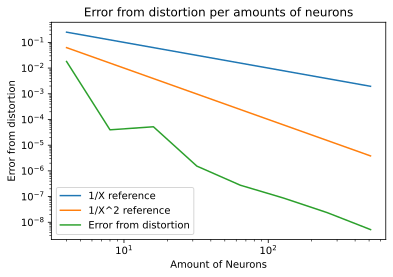

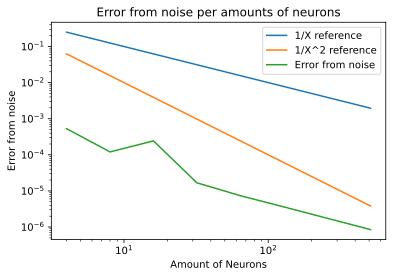

In [8]:
error_plots(0.01)

**c) Interpretation.** What does the difference between the graphs in a) and b) tell us about the sources of error in neural populations?

From the difference in a and b, we can see that the error is greater across neuron amounts in part a compared to part b for both noise and distortion. This difference is caused by the larger standard deviation of noise due to the increased coefficient value, meaning that having larger standard deviations of noise in a signal increases the error from noise and distortion in neural populations.

Also, in both a and b, the error from distortion is proportional to the 1/X^2 curve, and the error from noise is proportional to the 1/X curve. This tells us that error from distortion decreases much more quickly than error from noise when adding more neurons to a decoder.

## 1.3 Leaky Integrate-and-Fire neurons

**a) Computing gain and bias.** As in the second part of 1.1a), given a maximum firing rate $a^\mathrm{max}$ and a bias $J^\mathrm{bias}$, write down the equations for computing $\alpha$ and the $J^\mathrm{bias}$ for this specific neuron model.

Using the equations for α and J_bias from part 1.1a), we have:

α = (G_inverse[a_max] - J_thresh) / (1-x_int)

J_bias = (J_thresh - x_int * G_inverse[a_max])/(1-x_int)

Therefore we need to find G_inverse for a LIF neuron.

G[J] = 1 / [𝜏_ref - 𝜏_RC * ln(1-(1/J))] -> 𝜏_ref - 𝜏_RC * ln(1-(1/J)) = 1 / G[J]

-> ln(1-(1/J)) = (𝜏_ref - 1/G[J]) / 𝜏_RC -> 1 - (1/J) = exp((𝜏_ref - 1/G[J]) / 𝜏_RC)

-> 1/J = 1 - exp((𝜏_ref - 1/G[J]) / 𝜏_RC) -> J = 1 / (1 - exp((𝜏_ref - 1/G[J]) / 𝜏_RC))

Subbing in a for G[J] gives:

G_inverse[a] = 1 / (1 - exp((𝜏_ref - 1/a) / 𝜏_RC))

Plugging this G_inverse into the above equations for α and J_bias gives:

α = ((1 / (1 - exp((𝜏_ref - 1/a_max) / 𝜏_RC))) - J_thresh) / (1-x_int)

J_bias = (J_thresh - x_int(1 / (1 - exp((𝜏_ref - 1/a_max) / 𝜏_RC))))/(1-x_int)

**b) Neuron tuning curves.** Generate the same plot as in 1.1b). Use $\tau_\mathrm{ref}=2 \mathrm{ms}$ and $\tau_{RC}=20 \mathrm{ms}$. Use the same distribution of $x$-intercepts and maximum firing rates as in 1.1.

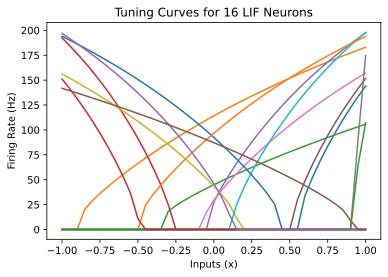

In [9]:
# using alpha and tau in place of α and 𝜏 for ease of typing
class NeuronModelLIF:
    def __init__(
        self,
        a_max,
        x_int,
        tau_ref=0.002,
        tau_rc=0.02
    ):
        self.a_max = a_max
        self.x_int = x_int
        self.tau_ref=tau_ref
        self.tau_rc=tau_rc
        self.G = self._G_LIF
        self.G_inv = self._G_LIF_inv
        self.encoder = np.random.choice([-1,1])
        
        self.j_bias = self._calc_j_bias()
        self.alpha = self._calc_alpha()     

    def _G_LIF(self,J):
        if J > 1:
            bot = self.tau_ref-self.tau_rc*np.log(1-1/J)
            
            return 1 / bot
        return 0
    
    def _G_LIF_inv(self,rate):
        return 1 / (1-np.exp((self.tau_ref-1/rate) / self.tau_rc))
    
    def _calc_j_bias(self):
        top = self.x_int*self.G_inv(self.a_max) - 1
        bot = self.x_int - 1
        return top / bot
    
    def _calc_alpha(self):
        top = 1 - self.G_inv(self.a_max)
        bot = self.x_int - 1
        return top / bot
    
    def sim(self,x):
        self.a = [
            self.G(self.encoder*self.alpha*xs + self.j_bias)
            for xs in x
        ]
        
        return self.a        

# Initialize x samples and number of neurons
x = np.linspace(-1,1,41)
n_neurons = 16

# Randomly initialize maximum firing rates and x-intercepts
samples_a_max = np.random.uniform(100,200,n_neurons)
samples_x_int = np.random.uniform(-0.95,0.95,n_neurons)

neurons = []

# Plot LIF neuron tuning curves
for a_max, x_int in zip(samples_a_max,samples_x_int):
    neuron = NeuronModelLIF(
        a_max=a_max,
        x_int=x_int
    )
    plt.plot(x,neuron.sim(x))
    neurons.append(neuron)

plt.title("Tuning Curves for 16 LIF Neurons")
plt.xlabel("Inputs (x)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

**c) Impact of noise.** Generate the same four plots as in 1.1f) (adding/not adding noise to $A$, accounting/not accounting for noise when computing $\vec d$), and report the RMSE both with and without noise.

RMSE not regularized no noise: 0.007176287836928359
RMSE not regularized with noise: 0.1849206752818083
RMSE regularized no noise: 0.03206197395356654
RMSE regularized with noise: 0.0918038212817261


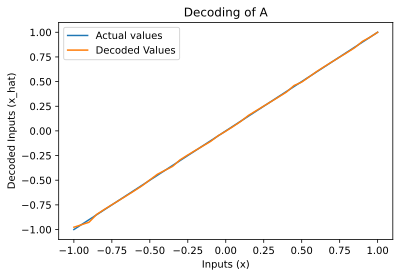

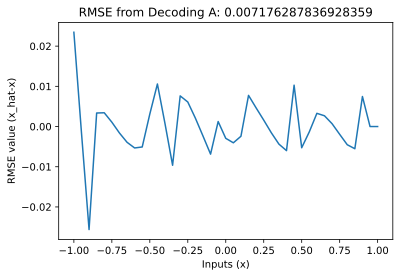

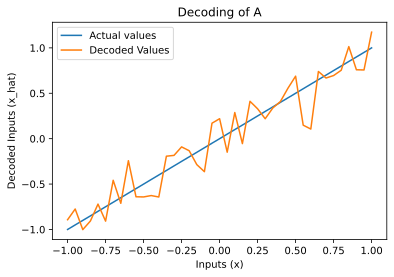

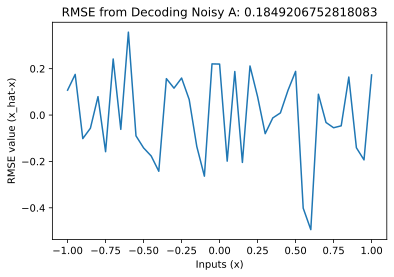

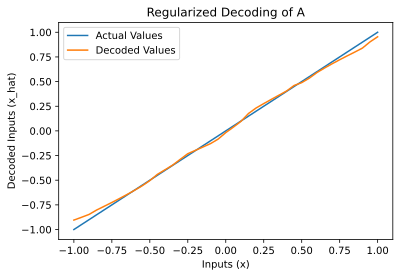

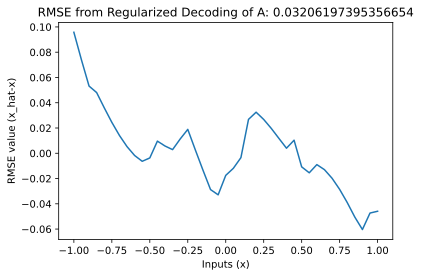

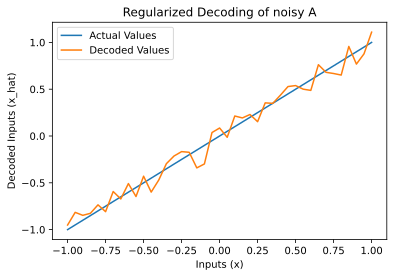

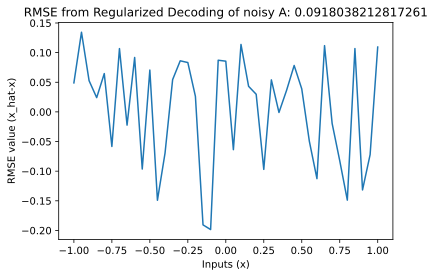

In [10]:
# For unregularized not noisy A

A = np.array([neuron.a for neuron in neurons])

decoder = calc_decoder(A,X)

x_decoded = decoder @ A

plt.figure()
plt.plot(x,x,label="Actual values")
plt.plot(x,x_decoded[0],label="Decoded Values")
plt.title("Decoding of A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded = x_decoded[0]-x
plt.figure()
plt.plot(x,residual_x_decoded)
plt.title(f"RMSE from Decoding A: {calc_RMSE(residual_x_decoded)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")


# For unregularized noisy A

noise_signal = np.random.normal(0,0.2*np.amax(A),A.shape)
A_noisy = A + noise_signal

x_decoded_noisy = decoder @ A_noisy

plt.figure()
plt.plot(x,x,label="Actual values")
plt.plot(x,x_decoded_noisy[0],label="Decoded Values")
plt.title("Decoding of A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded_noisy = x_decoded_noisy[0]-x
plt.figure()
plt.plot(x,residual_x_decoded_noisy)
plt.title(f"RMSE from Decoding Noisy A: {calc_RMSE(residual_x_decoded_noisy)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")


# For regularized not noisy A

decoder_reg = calc_regularized_decoder(A,X)

x_decoded_reg = decoder_reg @ A
plt.figure()
plt.plot(x,x,label="Actual Values")
plt.plot(x,x_decoded_reg[0],label="Decoded Values")
plt.title("Regularized Decoding of A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded_reg = x_decoded_reg[0]-x
plt.figure()
plt.plot(x,residual_x_decoded_reg)
plt.title(f"RMSE from Regularized Decoding of A: {calc_RMSE(residual_x_decoded_reg)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")

x_decoded_reg_noisy = decoder_reg @ A_noisy
plt.figure()
plt.plot(x,x,label="Actual Values")
plt.plot(x,x_decoded_reg_noisy[0],label="Decoded Values")
plt.title("Regularized Decoding of noisy A")
plt.xlabel("Inputs (x)")
plt.ylabel("Decoded Inputs (x_hat)")
plt.legend()

residual_x_decoded_reg_noisy = x_decoded_reg_noisy[0]-x
plt.figure()
plt.plot(x,residual_x_decoded_reg_noisy)
plt.title(f"RMSE from Regularized Decoding of noisy A: {calc_RMSE(residual_x_decoded_reg_noisy)}")
plt.xlabel("Inputs (x)")
plt.ylabel("RMSE value (x_hat-x)")

print(f'RMSE not regularized no noise: {calc_RMSE(residual_x_decoded)}')
print(f'RMSE not regularized with noise: {calc_RMSE(residual_x_decoded_noisy)}')
print(f'RMSE regularized no noise: {calc_RMSE(residual_x_decoded_reg)}')
print(f'RMSE regularized with noise: {calc_RMSE(residual_x_decoded_reg_noisy)}')

# 2. Reperesentation of Vectors

## 2.1 Vector tuning curves

**a) Plotting 2D tuning curves.** Plot the tuning curve of an LIF neuron whose 2D preferred direction vector is at an angle of $\theta=-\pi/4$, has an $x$-intercept at the origin $(0,0)$, and has a maximum firing rate of $100 \mathrm{Hz}$.

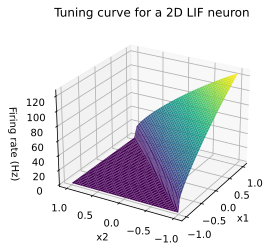

In [11]:
class NeuronModelLIF2D:
    def __init__(
        self,
        a_max,
        x_int,
        angle,
        tau_ref=0.002,
        tau_rc=0.02
    ):
        self.a_max = a_max
        self.x_int = x_int
#         self.angle = angle
        self.tau_ref=tau_ref
        self.tau_rc=tau_rc
        self.encoder = np.array([np.cos(angle),np.sin(angle)])
        self.G = self._G_LIF
        self.G_inv = self._G_LIF_inv
        
        self.j_bias = self._calc_j_bias()
        self.alpha = self._calc_alpha()     

    def _G_LIF(self,J):
        if J > 1:
            bot = self.tau_ref-self.tau_rc*np.log(1-1/J)
            return 1 / bot
        return 0
    
    def _G_LIF_inv(self,rate):
        return 1 / (1-np.exp((self.tau_ref-1/rate) / self.tau_rc))
    
    def _calc_j_bias(self):
        top = self.x_int*self.G_inv(self.a_max) - 1
        bot = self.x_int - 1
        return top / bot
    
    def _calc_alpha(self):
        top = 1 - self.G_inv(self.a_max)
        bot = self.x_int - 1
        return top / bot
    
    def sim(self,x1, x2):
        self.a = []
        for x1s, x2s in zip(x1,x2):
            self.a.append(self.G(np.dot(self.encoder,np.array([x1s,x2s]))*self.alpha + self.j_bias))
        return np.array(self.a)

    def sim_angle(self,angles,magnitudes=None):
        a = []
        if magnitudes is None:
            magnitudes = [1 for angle in angles]
        for angle, magnitude in zip(angles, magnitudes):
            x1 = magnitude * np.cos(angle)
            x2 = magnitude * np.sin(angle)
            
            a.append(
                self.G(
                    np.dot(self.encoder,np.array([x1,x2]))*self.alpha + self.j_bias
                )
            )
        return a

neuron = NeuronModelLIF2D(100,0,-np.pi/4)
x1, x2 = np.meshgrid(x,x)

plt.figure()
X = np.stack([x1,x2]).reshape(2,-1)
ax = plt.axes(projection="3d")
ax.plot_surface(x1,x2,neuron.sim(X[0],X[1]).reshape(x1.shape),cmap="viridis")
ax.set_title("Tuning curve for a 2D LIF neuron")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("Firing rate (Hz)")
ax.view_init(25,-150)

**b) Plotting the 2D tuning curve along the unit circle.** Plot the tuning curve for the same neuron as in a), but only considering the points around the unit circle, i.e., sample the activation for different angles $\theta$. Fit a curve of the form $c_1 \cos(c_2\theta+c_3)+c_4$ to the tuning curve and plot it as well.

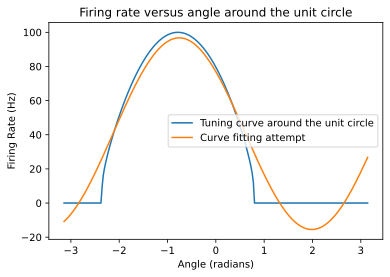

In [12]:
angle = np.linspace(-np.pi,np.pi,256)
y_val = neuron.sim_angle(angle)
plt.plot(angle,y_val,label="Tuning curve around the unit circle")

def curve_fitting(theta,c1,c2,c3,c4):
    return c1 * np.cos(c2*theta + c3) + c4

c_constants, _ = scipy.optimize.curve_fit(curve_fitting,angle,y_val)
plt.plot(angle,curve_fitting(angle,*c_constants),label="Curve fitting attempt")
plt.title("Firing rate versus angle around the unit circle")
plt.xlabel("Angle (radians)")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

**c) Discussion.** What makes a cosine a good choice for the curve fit in 2.1b? Why does it differ from the ideal curve?

A cosine function is a good choice for this curve fitting as the firing rate of the LIF neuron fires maximially at $\theta=-\pi/4$ and decreases non-linearly as the angle becomes further from the ideal (this happens because the firing rate is proportional to the dot product of the input angle and the ideal angle). Cosine is therefore a good choice as the dot product operation is proportional to the cosine of angle between the vectors.

The fitted curve differs from the ideal however as cosine is a sinusodal function, meaning it continuously repeats (makes the spiking pattern), but the LIF neuron only spikes when $\theta=-\pi/4$ and produces 0 for anything farther than a few radians away (i.e. does not continue to spike). In order to better match this behavious, the cosine function would need to be alters, perhaps with something like a unit step/ReLU function that results in a 0 reading outside of the neurons firing range.

## 2.2 Vector representation

**a) Choosing encoding vectors.** Generate a set of $100$ random unit vectors uniformly distributed around the unit circle. These will be the encoders $\vec e$ for $100$ neurons. Plot these vectors with a quiver or line plot (i.e., not just points, but lines/arrows to the points).

(-1.1, 1.1)

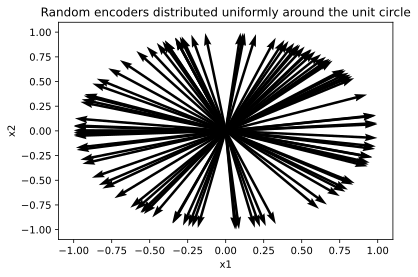

In [13]:
angles = np.random.uniform(-np.pi,np.pi,100)

for angle in angles:
    plt.quiver(0,0,np.cos(angle),np.sin(angle),angles="xy",scale_units="xy",scale=1)

plt.title("Random encoders distributed uniformly around the unit circle")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

**b) Computing the identity decoder.** Use LIF neurons with the same properties as in question 1.3. When computing the decoders, take into account noise with $\sigma = 0.2\max(A)$. Plot the decoders in the same way you plotted the encoders.

(-0.00042, 0.00042)

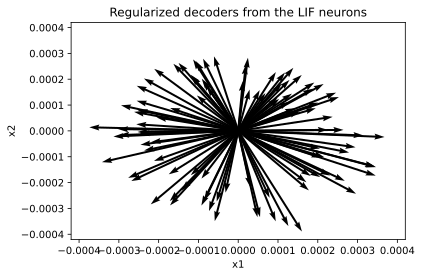

In [14]:
samples_a_max = np.random.uniform(100,200,100)
samples_x_int = np.random.uniform(-0.95,-0.95,100)

neurons = []

for a_max, x_int, angle in zip(samples_a_max,samples_x_int,angles):
    neurons.append(NeuronModelLIF2D(a_max, x_int, angle))

A = np.array([neuron.sim(X[0],X[1]) for neuron in neurons]).reshape(100,-1)

decoder_reg = calc_regularized_decoder(A,X,0.2,100)

plt.quiver([0]*100,[0]*100,decoder_reg[0],decoder_reg[1],angles="xy",scale_units="xy",scale=1)
plt.title("Regularized decoders from the LIF neurons")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-0.00042,0.00042)
plt.ylim(-0.00042,0.00042)

**c) Discussion.** How do these decoding vectors compare to the encoding vectors?

When comparing the decoder vectors to the encoding vectors, it can be seen that the decoder vectors are not uniform in magnitude as the encoding ones are, and they also have much smaller magnitudes compared to the encoding vectors (I would guess this is due to regularizing for noise causing smaller decoding vectors from the prevented overfitting?). The angles appear similar between both sets of vectors, however, with no angles apparently prefered in the distribution of either vector set.

**d) Testing the decoder.** Generate 20 random $\vec x$ values throughout the unit circle (i.e.,~with different directions and radiuses). For each $\vec x$ value, determine the neural activity $a_i$ for each of the 100 neurons. Now decode these values (i.e. compute $\hat{x} = D \vec a$) using the decoders from part b). Plot the original and decoded values on the same graph in different colours, and compute the RMSE.

The RMSE for this comparison is 0.019851212939610122


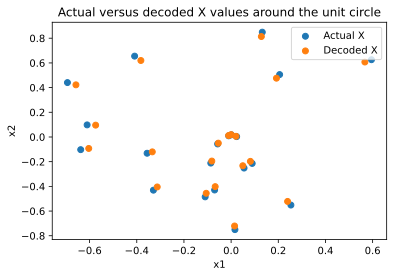

In [15]:
angles = np.random.uniform(-np.pi,np.pi,20)
mags = np.random.uniform(0,1,20)

x = []
for angle, mag in zip(angles,mags):
    x.append([mag*np.cos(angle),mag*np.sin(angle)])
X = np.transpose(np.array(x),(1,0))

A = np.array([neuron.sim(X[0],X[1]) for neuron in neurons]).reshape(100,-1)
X_decoded = decoder_reg @ A

# Generate scatter plot of x values and their decoded versions
plt.scatter(X[0],X[1],label="Actual X")
plt.scatter(X_decoded[0],X_decoded[1],label="Decoded X")
plt.title("Actual versus decoded X values around the unit circle")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
print(f'The RMSE for this comparison is {calc_RMSE(X_decoded.flatten()-X.flatten())}')

**e) Using encoders as decoders.** Repeat part d) but use the *encoders* as decoders. This is what Georgopoulos used in his original approach to decoding information from populations of neurons. Plot the decoded values and compute the RMSE. In addition, recompute the RMSE in both cases, but ignore the magnitude of the decoded vectors by normalizing before computing the RMSE.

The RMSE for the not normalized comparison is 1462.29955706799
The RMSE for the normalized comparison is 0.6313391273408612


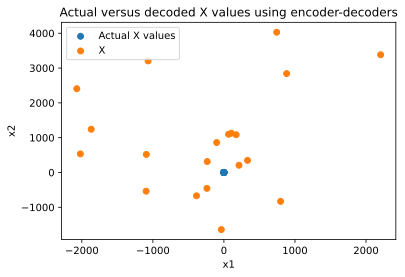

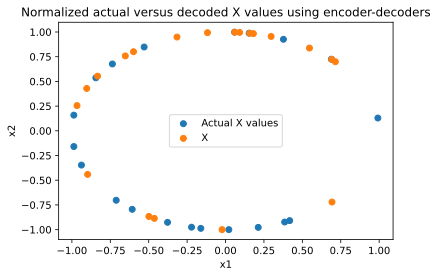

In [16]:
plt.figure()
encoder_array = np.transpose(np.array([neuron.encoder for neuron in neurons]),(1,0))
X_decoded = encoder_array @ A

plt.scatter(X[0],X[1],label="Actual X values")
plt.scatter(X_decoded[0],X_decoded[1],label="X")
plt.title("Actual versus decoded X values using encoder-decoders")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
print(f'The RMSE for the not normalized comparison is {calc_RMSE(X_decoded.flatten()-X.flatten())}')

plt.figure()
for i in range(X.shape[1]):
    X[:,i] = X[:,i] / np.linalg.norm(X[:,i])
    X_decoded[:,i] = X_decoded[:,i] / np.linalg.norm(X_decoded[:,i])

plt.scatter(X[0],X[1],label="Actual X values")
plt.scatter(X_decoded[0],X_decoded[1],label="X")
plt.title("Normalized actual versus decoded X values using encoder-decoders")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
print(f"The RMSE for the normalized comparison is {calc_RMSE(X_decoded.flatten()-X.flatten())}")

**f) Discussion.** When computing the RMSE on the normalized vectors, using the encoders as decoders should result in a larger, yet still surprisingly small error. Thinking about random unit vectors in high dimensional spaces, why is this the case? What are the relative merits of these two approaches to decoding?

In the not normalized case, the actual X values were between 0 and 1, but the decoded X values had values in the thousands, which results in a massive RMSE (also in the thousands). After normalization, however, the decoded X values were between 0 and 1 and the RMSE was orders of magnitude smaller (less than 1). This massive difference in RMSE from normalization indicates that the vast majority of RMSE was coming from the magnitude differences between the actual and decoded values. When thinking about this in terms of unit vectors in high dimensional spaces, this makes sense as the error is just coming from euclidean distance between the vector tips as a result of misprojection into vector space, with any error from magitude of the vectors being removed from the calculation of vector tip location difference.

The relative merit of doing the first approach to decoding is that the decodings are more accurate and provide lower RMSE. The relative merit of using encoders as decoders is the reduction in computational costs of the algorithm due to the replacement of more expensive matrix inverse operations with cheaper normalization operations.